In [1]:
import numpy as np
import matplotlib.pyplot as plt

from bayesian_network import BayesNet, Variable
from utils import sample_categorical
from typing import Iterator

# Topological Sort

For Likelihood Weighting, we need to implement a `sample_lw` function that requires iterating over the network's variables in a topologically sorted way. For this purpose, we can **reuse** our implementation from **Problem 1**. 

<div class="alert alert-warning">
Copy your implementation of topological sort from Problem 1 to the cell below.
</div>

In [2]:
def __iter__(self) -> Iterator[Variable]:
    """
    Iterates over all variables in the Bayesian network in topological ordering, i.e.,
    for an edge from a variable X to a variable Y, X is returned before Y.  
    Since a Bayesian network is a directed acyclic graph, a topological ordering can always be found. 

    :yields: variable after variable according to the network's topology.
    """
    
    # list of topologically sorted variables to be returned
    sorted_variables = list()  
    # all variables in the network encoded as a dictionary (keys: variable ids, values: Variable objects)
    variables = self.nodes  
    

    # My plan: count for each node its deepest depth within the network paths. The deepest depth determines
    # its position within the output list.
    
    # 1. find nodes without parents:
    parent_list = []
    for (id_,value) in self.nodes.items():
        if len(value.parents) == 0:
            parent_list.append(id_)
 
    # 2. go all paths to find the deepest depths:
    # create for each variable a dictionary entry which stores it depth:
    depth_dict = {var:0 for var in variables.keys()}
    
    def inner_func(depth, current_set):
        
        for variable_id in current_set:
            
            depth_dict[variable_id] = depth
            variable_ele = variables[variable_id]
            
            if len(variable_ele.children) > 0:
                
                set_children = variable_ele.children # gives IDs
                
                depth += 1 
                inner_func(depth, set_children) # go one deeper by stepping down to the children
            
    inner_func(depth=0, current_set=parent_list)

    # 3. reformulate the found output to a topologically correctly ordered list:
    sorted_variables_id = dict(sorted(depth_dict.items(), key=lambda item: item[1])).keys()

    sorted_variables = [variables[id_] for id_ in sorted_variables_id]

    for node in sorted_variables:
        yield node

# bind the implemented iterator method to the BayesNet
BayesNet.__iter__ = __iter__

In [3]:
# sanity checks
A = np.ones((2,)) / 2
B_AC = np.ones((2,2,2)) / 2
C_A = np.ones((2,2)) / 2
D_BC = np.ones((2,2,2)) / 2

_A_, _B_, _C_, _D_ = 0, 1, 2, 3

bayes_net = BayesNet(
    (A, [_A_]),
    (B_AC, [_B_, _A_, _C_]),
    (C_A, [_C_, _A_]),
    (D_BC, [_D_, _B_, _C_])
)

top_sorted_vars = (_A_, _C_, _B_, _D_)
output = []

for i, variable in enumerate(bayes_net):
    assert isinstance(variable, Variable), f"\nWrong output type!\nExpected: Variable\nGiven: \t {type(variable)}"
    assert variable.id == top_sorted_vars[i], f"\nWrong ordering!\nExpected: \
        {top_sorted_vars}\nGiven: \t ID {variable.id} at position {i+1}"
    output.append(variable)
assert len(output) == len(top_sorted_vars), f"\nWrong number of variables!\nExpected: \
    {len(top_sorted_vars)}\nGiven: \t{len(output)}"
    

# Likelihood Weighting

This notebook will implement the likelihood weighting algorithm and use it to approximate the probabilistic query $P(A \mid D, E)$ for the Bayesian Network given below. In likelihood weighting, we do not throw away samples. Instead, we force the samples to have the correct evidence but weight them according to the evidence's likelihood.

To make your solutions testable, we ask you to implement two functions, namely:
- `sample_lw`, and
- `likelihood_weighting`.

`sample_lw` returns a set of *samples* from the mutilated network ($\mathcal{B}_{E=e}$, all consistent with the evidence $\mathbf{e}$) and the corresponding weights for likelihood weighting. 

`likelihood_weighting` uses *sample_lw* and approximates $P(X \mid \mathbf{E}=e)$. Again, we will only consider probabilistic queries with one query variable $X$.

### Sampling from the Mutilated Network
<div class="alert alert-warning">
    Implement the <i>sample_lw</i> function, which samples from the mutilated network $\mathcal{B}_{E=e}$. (3 points)
</div>

The `sample_lw` function must return a tuple with two objects:
- samples from $\mathcal{B}_{\mathbf{E}=\mathbf{e}}$ of type `np.ndarray`, with shape `(sample_size, len(bayes_net))`, and
- weights for each sample of type `np.ndarray` with shape `(sample_size,)`

**Hints**: 
- If you have correctly implemented the topological sort, iterating over the *BayesNet* object returns the *Variable* objects in topological ordering. The 1-D probability distribution of variable $X$ given its parents $\mathit{pa}(X)$, $P(X \mid \mathit{pa}(X))$, can be obtained by passing the (possibly incomplete) random event to the variable, i.e., `variable(samples[i])`.
-  Use the `sample_categorical()` function to sample from a 1D-distribution.

In [4]:
from utils import sample_categorical
help(sample_categorical)

Help on function sample_categorical in module utils:

sample_categorical(dist: numpy.ndarray) -> numpy.int64
    Draws a single sample from a categorical distribution.
    :param dist: NumPy array listing the probability of each outcome.
    :returns: Index of the sampled element.



In [5]:
def sample_lw(bayes_net: BayesNet, sample_size: int, evidence: dict={}):
    '''
    Samples from the mutilated network.
    :param bayes_net: A Bayesian network of type BayesNet.
    :param sample_size: The number of samples to draw from the Bayesian network.
    :param evidence: A dictionary of evidence variables (keys, int) and their correponding values (values, int).
    :returns: A NumPy array of type np.int64 with shape (sample_size, len(bayes_net)),
              and a NumPy array of shape (sample_size,) with the corresponding weight for each sample.
    '''
    
    # arrays holding the samples and the weights
    samples = np.empty((sample_size, len(bayes_net)), np.int64)
    weights = np.ones(sample_size)
    
    
    # lecture 04b, page 27 + 28
    
    for sample_round in range(sample_size):
        
        for i, variable in enumerate(bayes_net):
            
            # sampling gets ignored when variable has no parents:
            distribution = variable(samples[sample_round]) # eg P(A)=[0.2,0.8]

            if variable.id in evidence.keys():

                weights[sample_round] *= distribution[evidence[variable.id]] # evidence value is the 
                # index which marks eg for A a_0/0.2 or a_1/0.8
                '''
                Higher weight for samples with high appearance rate.
                '''
                samples[sample_round, variable.id] = evidence[variable.id]

            else: # like forward sampling

                found_sample = sample_categorical(distribution) # get index of chosen sample of P(A)

                samples[sample_round, variable.id] = found_sample

    
    return samples, weights

In [6]:
# sanity checks
bayes_net = BayesNet((np.array([0.5, 0.5]), [0]))

samples, weights = sample_lw(bayes_net, 3)

assert type(samples) == np.ndarray, f'\nWrong output type!\nExpected: np.ndarray\nGiven:\t  {type(samples)}'
assert samples.shape == (3, 1), f'\nWrong output shape!\nExpected: (3, 1)\nGiven:\t  {samples.shape}'
assert samples.dtype == np.int64, f'\nWrong numpy array data type!\nExpected: np.int64\nGiven:\t  {samples.dtype}'
assert type(weights) == np.ndarray, f'\nWrong output type!\nExpected: np.ndarray\nGiven:\t  {type(weights)}'
assert weights.shape == (3,), f'\nWrong output shape!\nExpected: (3,)\nGiven:\t  {weights.shape}'
assert weights.dtype == np.float64, f'\nWrong numpy array data type!\nExpected: np.float64\nGiven:\t  {weights.dtype}'
assert ((0 <= weights) & (weights <= 1)).all(), f'All weights must lie in range [0,1]\n Got: {weights}'

### Likelihood Weighting
<div class="alert alert-warning">
Implement the <i>likelihood_weighting</i> function, which estimates the probability distribution over the query variable $X$ given the evidence $\mathbf{E}=\mathbf{e}$, $P(X \mid \mathbf{E}=\mathbf{e})$. Use the <i>sample_lw</i> function implemented in the previous step. (3 points) 
</div>

The `likelihood_weighting` function must return one object:
-  The 1-D probability distribution over variable $X$ of type `np.ndarray` with shape `(bayes_net[query_variable].num_values,)`.

**Hints**: 
- Use `np.bincount` to count the number of occurrences of each value. It even supports weights -- check its [documentation](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html)!
- For simplicity, we will only consider probabilistic queries with one query variable $X$.

In [7]:
def likelihood_weighting(bayes_net: BayesNet, query_variable: int, evidence: dict={}, sample_size: int=100):
    '''
    Estimates the distribution of the query variable given the value of the evidence variables.
    :param bayes_net: A Bayesian network of type BayesNet.
    :param query_variable: The query variable (int).
    :param evidence: A dictionary of evidence variables (keys, int) and their correponding values (values, int).
    :param sample_size: The number of samples to use for the estimation.
    :returns: A NumPy array of type np.float64 representing the conditional distribution of the query variable
              given evidence.
    '''
    
    # forward sample...
    samples, weights = sample_lw(bayes_net, sample_size, evidence=evidence)

    
    found_query_values = samples[:, query_variable]
    number_query_appearences = np.bincount(found_query_values, minlength=bayes_net[query_variable].num_values, weights=weights)
    
    distribution = number_query_appearences / np.sum(number_query_appearences)
    
    return distribution

In [8]:
# sanity checks
bayes_net = BayesNet((np.array([0.25, 0.25, 0.5]), [0]))

np.random.seed(0)
distribution = likelihood_weighting(bayes_net, 0, {}, 1000)
assert type(distribution) == np.ndarray, f'\nWrong output type!\nExpected: np.ndarray\nGiven:\t  {type(distribution)}'
assert distribution.shape == (3,), f'\nWrong output shape!\nExpected: (3,)\nGiven:\t  {distribution.shape}'
assert distribution.dtype == np.float64, f'\nWrong numpy array data type!\nExpected: np.float64\nGiven:\t  {distribution.dtype}'
assert np.isclose(distribution.sum(), 1.), f'\bProbabilities must sum to 1. Got: {distribution.sum()}'

## Example


Reconsider the Bayesian Network from the previous problem:

<img width='30%' src='bn.svg'>

The conditional probability tables are given as:

<table style="float: left;margin:5px;"><tr><th>P(A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>-</td><td>0.2</td><td>0.8</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(B | A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>$b_0$</td><td>0.9</td><td>0.2</td></tr><tr><td>$b_1$</td><td>0.1</td><td>0.8</td></tr></table>

<table style="float: left;margin:5px;"><tr><th rowspan="2">P(D | A, B)</th><th colspan="2">$a_0$<br></th><th colspan="2">$a_1$</th></tr><tr><td>$b_0$</td><td>$b_1$</td><td>$b_0$</td><td>$b_1$</td></tr><tr><td>$d_0$<br></td><td>0.1</td><td>0.2</td><td>0.01</td><td>0.8</td></tr><tr><td>$d_1$</td><td>0.9</td><td>0.8</td><td>0.99</td><td>0.2</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(C|D)</th><th>$d_0$<br></th><th>$d_1$</th></tr><tr><td>$c_0$</td><td>0.95</td><td>0.15</td></tr><tr><td>$c_1$</td><td>0.05</td><td>0.85</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(E | C)</th><th>$c_0$</th><th>$c_1$</th></tr><tr><td>$e_0$</td><td>0.9</td><td>0.4</td></tr><tr><td>$e_1$</td><td>0.1</td><td>0.6</td></tr></table>

In [9]:
_A_, _B_, _C_, _D_, _E_ = 0, 1, 2, 3, 4

A = np.array([0.2, 0.8])
B_A = np.array([[0.9, 0.2], [0.1, 0.8]])
C_D = np.array([[0.95, 0.15], [0.05, 0.85]])
D_AB = np.array([[[0.1, 0.2], [0.01, 0.8]], [[0.9, 0.8], [0.99, 0.2]]])
E_C = np.array([[0.9, 0.4], [0.1, 0.6]])
              
bayes_net = BayesNet(
    (A, [_A_]),
    (B_A, [_B_, _A_]),
    (C_D, [_C_, _D_]),
    (D_AB, [_D_, _A_, _B_]),
    (E_C, [_E_, _C_])
)

### Exact Computation
<div class="alert alert-warning">
Compute $P(A \mid D, E)$ exactly (up to floating point precision).  (1 point)
</div>

**Hint**: Copy the computation / the result from **Problem 1**.

In [10]:
A_DE = None

# 1. compute FJDT
fjdt = 1

for variable in bayes_net:
    fjdt = fjdt * variable.pdt

# 2. get P(A, D, E) :
id_A = {bayes_net[_A_].id}
id_D = {bayes_net[_D_].id}
id_E = {bayes_net[_E_].id}
id_all = set([i for i in range(len(bayes_net))])
set_unpart_id = id_all - id_A - id_D - id_E

ADE_fjdt = np.sum(fjdt, axis=tuple(set_unpart_id), keepdims=True)
ADE_fjdt.shape

# 3. get P(D, E):
DE_fjdt = np.sum(ADE_fjdt, axis=tuple(id_A), keepdims=True)

# 4. final result:
A_DE = ADE_fjdt/DE_fjdt
A_DE = A_DE.squeeze() # remove unneeded dimensions

In [11]:
# sanity checks
assert A_DE is not None
assert A_DE.shape == (2,2,2)
assert np.all(np.isclose(A_DE.sum(axis=0), 1))

### Comparison

Run the following code cell to plot the average [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the exact distribution $P(A \mid D, E)$ and the approximations computed with likelihood weighting. Different lines represent different value assignments to the evidence variables $D$ and $E$.

**Hint**: The computation of the approximations might take a while...

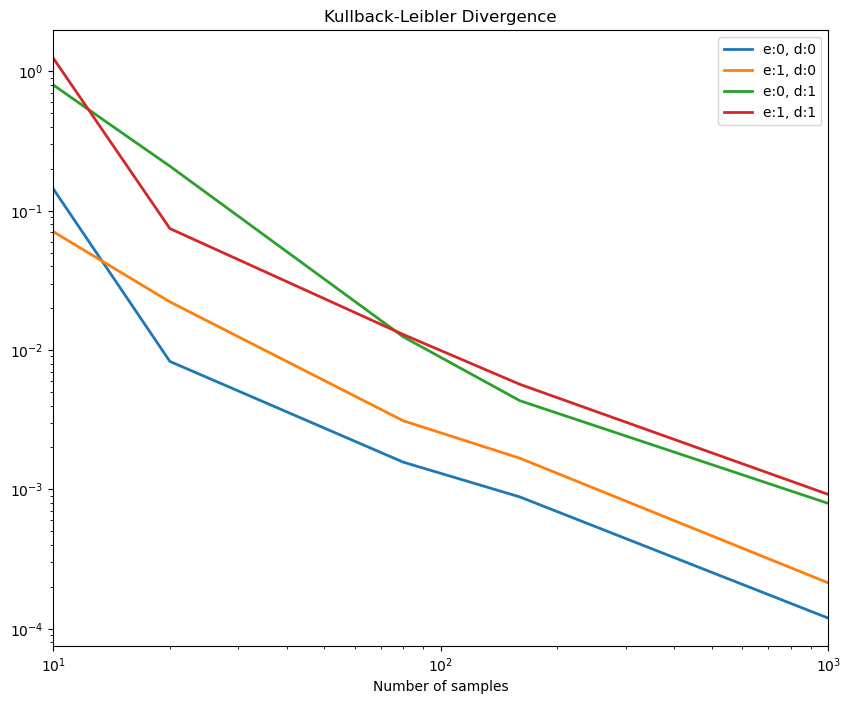

In [12]:
from utils import approx_error

np.random.seed(0)
errs = {}
sample_counts = np.array([10, 20, 80, 160, 1000])

# compute approximation error
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    errs[(d, e)] = approx_error(
        bayes_net,
        likelihood_weighting,  
        A_DE[:, d, e],
        _A_,
        {_D_:d, _E_:e}, 
        sample_counts,
        n_runs=100
    )

# plot
plt.figure(figsize=(10, 8))
plt.title('Kullback-Leibler Divergence')
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    plt.plot(sample_counts, errs[(d, e)], label=f'e:{e}, d:{d}', lw=2)
    
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(sample_counts.min(), sample_counts.max())
plt.xlabel('Number of samples')
plt.show()

### Edge Count

<div class="alert alert-warning">
Implement the function <i>edge_count</i> that computes the number of edges in a mutilated Bayesian network. (1 point)
</div>

The `edge_count` function must return a single integer corresponding to the total number of edges in the mutilated network $\mathcal{B}_{E=e}$.

**Hints:**
- parent variable IDs (set of integers) can be accessed using ```variable.parents```

In [13]:
def edge_count(bayes_net: BayesNet, evidence: tuple = ()):
    '''
    Calculate the number of edges in the mutilated network given a tuple of evidence variable ids.
    :param bayes_net: A Bayesian network of type BayesNet.
    :param evidence: A tuple containing the ids of evidence variables.
    :returns: An integer indicating the number of edges in the mutilated network
    '''

    # number of edges
    edges = 0
    
    # find all leaf nodes in the bayes net:
    leaf_nodes = []
    for i, variable in enumerate(bayes_net):
        if len(variable.children) == 0:
            leaf_nodes.append(variable.id)

    # go from buttom to top: 
    def inner_func(current_nodes):
        
        for id_ in current_nodes:
            
            if id_ not in evidence: # evidence variables have no parents in mutilated net
                
                parents = bayes_net.nodes[id_].parents # gives IDs
                
                if len(parents)>0:
                    
                    nonlocal edges
                    edges += len(parents)
                    
                    inner_func(parents)
                    
    inner_func(leaf_nodes)
    
    
    return edges

In [14]:
# sanity checks
_A_, _B_ = 0, 1
A = np.array([0.2, 0.8])
B_A = np.array([[0.9, 0.2], [0.1, 0.8]])

bayes_net = BayesNet(
    (A, [_A_]),
    (B_A, [_B_, _A_])
)

edges = edge_count(bayes_net, ())
assert type(edges) == int
assert edges == 1

edges = edge_count(bayes_net, (_B_,))
assert type(edges) == int
assert edges == 0


<div class="alert alert-warning">
Store the answer to the following question into the provided result variables! (1 point)
</div>

Given the Bayesian network defined above, the query $P(A \mid B=0, D=1)$ and the following samples:

* (1) $a_0,b_1,c_1,d_1,e_0$
* (2) $a_1,b_0,c_1,d_0,e_1$
* (3) $a_1,b_0,c_1,d_1,e_1$

Decide which of the samples would not be rejected by Rejection Sampling. For the sample that is not rejected, calculate the weight that likelihood weighting would attach to it. Put the index of the not rejected sample (1, 2 or 3) in the variable ```sample_index``` and the weight that likelihood weighting would assign to it in variable ```sample_weight```.

In [15]:
sample_index = 3 # store the index of the correct answer into this variable (integer)
sample_weight = 0.198 # sample_lw(bayes_net, sample_size=1, evidence={1:0, 3:1})
# store the weight of the not rejected sample into this variable (float)

In [16]:
assert sample_index is not None
assert sample_weight is not None

<div class="alert alert-warning">
Answer the following question in <b>one sentence</b>! (1 point)
</div>

Given the Bayesian network defined above, which type of query is better suited for likelihood weighting, $P(A|E)$ or $P(E|A)$? Explain your answer.

P(E|A) because A is an ancestor of E. Add on: upstream sample